In [99]:
import json
import random
import string
import datetime
import time
import uuid
import numpy as np
import math

## InsuranceQuoteRequestEvents metrics from baseline and constrained apps

We compute the processing overhead of the baseline (without any constraints applied) and the Constrained solution (a Stream processing application with Stream Constraints applied). Processing overhead in this case refers to time taken from when the event was produced (the appended timestamp to the produced event) to when the event is consumed (the appended timestamp of when the event was consumed).

Another topic is used to collect the event metrics, called the metric-events topic which we then use for analysis. Lakeside Mutual consumers publish metrics to the metric-events topic. An event in this topic is represented as follows:

```java
public class MetricEvent implements DomainEvent {
    private String eventId; // id of the domain event - whether insurance quote or policy
    private Date producedAt; // timestamp the event was produced
    private Date consumedAt; // timestamp the event was consumed
    private String eventType; // the type of event: InsuranceQuoteRequestEvent | UpdatePolicyEvent | DeletePolicyEvent
}
```

In [100]:
def create_event_map(filename):
    events_list = []
    with open(filename, "r") as file:
        for line in file.readlines():
            line_split = line.split(" ")
            events_list.append((line_split[0], line_split[1], line_split[2], line_split[3]))
    events_list.sort(key=lambda x: int(x[1]))
    events_map = {}
    for event in events_list:
        events_map.setdefault(event[0],[]).append((event[3], event[1], event[2]))
    return events_map, events_list

In [101]:
processed_events_1000_baseline, processed_events_1000_baseline_list = create_event_map("extended-events-baseline-1000.txt")
processed_events_1000_constrained, processed_events_1000_constrained_list = create_event_map("extended-events-constrained-1000.txt")
processed_events_1500_baseline, processed_events_1500_baseline_list = create_event_map("extended-events-baseline-1500.txt")
processed_events_1500_constrained, processed_events_1500_constrained_list = create_event_map("extended-events-constrained-1500.txt")
processed_events_2000_baseline, processed_events_2000_baseline_list = create_event_map("extended-events-baseline-2000.txt")
processed_events_2000_constrained, processed_events_2000_constrained_list = create_event_map("extended-events-constrained-2000.txt")
processed_events_2500_baseline, processed_events_2500_baseline_list = create_event_map("extended-events-baseline-2500.txt")
processed_events_2500_constrained, processed_events_2500_constrained_list = create_event_map("extended-events-constrained-2500.txt")

len(list(processed_events_1000_baseline.keys())) 
# number of keys generated should be 200

200

## Measuring time taken to process Baseline - 1000 events

In [102]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import numpy as np
from statistics import mean, median, stdev

In [103]:
events_latency_list = list(processed_events_1000_baseline.values())
events_latency = [item for sublist in events_latency_list for item in sublist]

baseline_diffs_1000 = list(map(lambda x: int(x[2]) - int(x[1]), events_latency))

events_latency_list = list(processed_events_1500_baseline.values())
events_latency = [item for sublist in events_latency_list for item in sublist]

baseline_diffs_1500 = list(map(lambda x: int(x[2]) - int(x[1]), events_latency))

events_latency_list = list(processed_events_2000_baseline.values())
events_latency = [item for sublist in events_latency_list for item in sublist]

baseline_diffs_2000 = list(map(lambda x: int(x[2]) - int(x[1]), events_latency))

events_latency_list = list(processed_events_2500_baseline.values())
events_latency = [item for sublist in events_latency_list for item in sublist]

baseline_diffs_2500 = list(map(lambda x: int(x[2]) - int(x[1]), events_latency))

In [104]:
mean(baseline_diffs_1000)

577.033

In [105]:
median(baseline_diffs_1000)

508.5

In [106]:
stdev(baseline_diffs_1000)

477.19458566038196

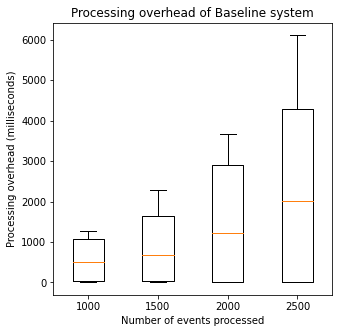

In [107]:
fig = plt.figure(figsize =(5, 5))

# Create plot
plt.boxplot([baseline_diffs_1000,baseline_diffs_1500, baseline_diffs_2000, baseline_diffs_2500])
plt.ylabel("Processing overhead (milliseconds)")
plt.xticks([1,2,3,4],["1000", "1500", "2000", "2500"])
plt.xlabel("Number of events processed")
plt.title("Processing overhead of Baseline system")

# show plot
plt.show()

fig.savefig("baseline-overhead.pdf") # normal distribution, explanation on why outliers were removed (possibly JVM garbage collection)

## Measuring time taken to process Constrained system - 1000 events

In [108]:
constrained_events_latency_list = list(processed_events_1000_constrained.values())
constrained_events_latency = [item for sublist in constrained_events_latency_list for item in sublist]
constrained_diffs_1000 = list(map(lambda x: int(x[2]) - int(x[1]), constrained_events_latency))

constrained_events_latency_list = list(processed_events_1500_constrained.values())
constrained_events_latency = [item for sublist in constrained_events_latency_list for item in sublist]
constrained_diffs_1500 = list(map(lambda x: int(x[2]) - int(x[1]), constrained_events_latency))

constrained_events_latency_list = list(processed_events_2000_constrained.values())
constrained_events_latency = [item for sublist in constrained_events_latency_list for item in sublist]
constrained_diffs_2000 = list(map(lambda x: int(x[2]) - int(x[1]), constrained_events_latency))

constrained_events_latency_list = list(processed_events_2000_constrained.values())
constrained_events_latency = [item for sublist in constrained_events_latency_list for item in sublist]
constrained_diffs_2500 = list(map(lambda x: int(x[2]) - int(x[1]), constrained_events_latency))

In [109]:
mean(constrained_diffs_1000)

652.554

In [110]:
median(constrained_diffs_1000)

109.5

In [111]:
stdev(constrained_diffs_1000)

732.8817836409859

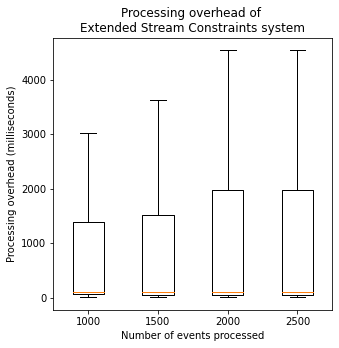

In [112]:
fig = plt.figure(figsize =(5, 5))

# create plot
plt.boxplot([constrained_diffs_1000, constrained_diffs_1500, constrained_diffs_2000, constrained_diffs_2500], showfliers=False)
plt.ylabel("Processing overhead (milliseconds)")
plt.xticks([1,2,3,4],["1000", "1500", "2000", "2500"])
plt.xlabel("Number of events processed")
plt.title("Processing overhead of \nExtended Stream Constraints system")

# show plot
plt.show()
# can reduce the scale and show outlier
fig.savefig("constrained-overhead.pdf") # distribution is positively skew

200


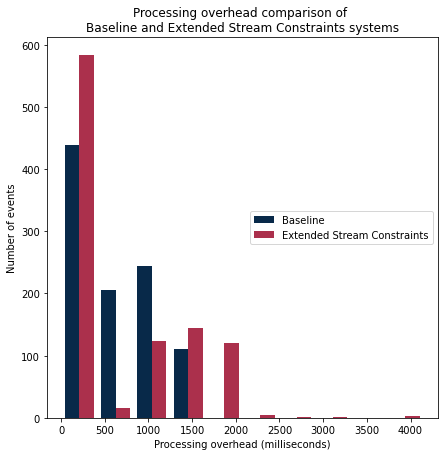

In [113]:
fig = plt.figure(figsize =(7, 7))
  
events = len(processed_events_1000_baseline.values())
print(events)

plt.hist([baseline_diffs_1000, constrained_diffs_1000], label=["Baseline", "Extended Stream Constraints"], color=["#082949", "#ab304c"])
plt.legend(loc="right")
plt.xlabel("Processing overhead (milliseconds)")
plt.ylabel("Number of events")
plt.title("Processing overhead comparison of \nBaseline and Extended Stream Constraints systems")
plt.show()

fig.savefig("baseline-constrained-overhead-1000-bar.pdf")

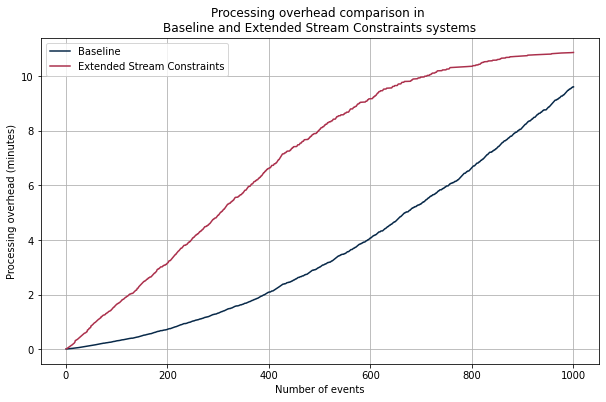

In [114]:

fig = plt.figure(figsize =(10, 6))

baseline_diffs_1000_y = list(map(lambda x: (int(x[2])-int(x[1]))/1000.0, processed_events_1000_baseline_list)) # to seconds
cumulative_diffs_1000_y = [math.fsum(baseline_diffs_1000_y[:i+1]) for i in range(len(baseline_diffs_1000_y))]
rounded_cumulative_diffs_1000_y =  list(map(lambda x: round(x/60.0,3), cumulative_diffs_1000_y)) # to minutes
diffs_x = list(range(1,len(baseline_diffs_1000_y)+1))

constrained_diffs_1000_y = list(map(lambda x: (int(x[2])-int(x[1]))/1000.0, processed_events_1000_constrained_list))
cumulative_constrained_diffs_1000_y = [math.fsum(constrained_diffs_1000_y[:i+1]) for i in range(len(constrained_diffs_1000_y))]
rounded_cumulative_constrained_diffs_1000_y =  list(map(lambda x: round(x/60.0,3), cumulative_constrained_diffs_1000_y))
constrained_diffs_x = list(range(1,len(constrained_diffs_1000_y)+1))


plt.plot(diffs_x, rounded_cumulative_diffs_1000_y, label="Baseline", color="#082949")
plt.plot(constrained_diffs_x, rounded_cumulative_constrained_diffs_1000_y, label="Extended Stream Constraints", color="#ab304c")

plt.legend(loc="best")
plt.xlabel("Number of events")
plt.ylabel("Processing overhead (minutes)")
plt.grid(True)
plt.title("Processing overhead comparison in \nBaseline and Extended Stream Constraints systems")
plt.show()

fig.savefig("baseline-constrained-overhead-1000-line.pdf")

## Measuring time taken to process Baseline and Constrained system - 2500 events

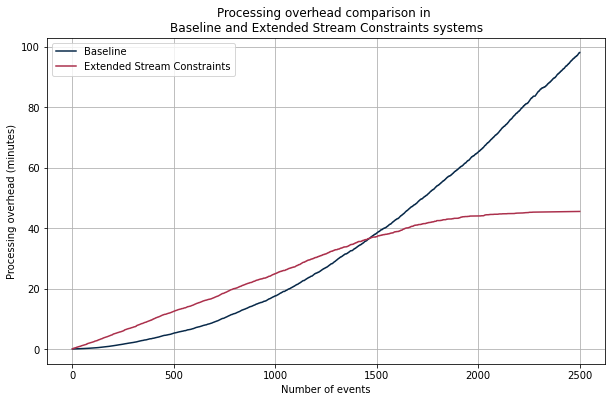

In [115]:

fig = plt.figure(figsize =(10, 6))

baseline_diffs_2500_y = list(map(lambda x: (int(x[2])-int(x[1]))/1000.0, processed_events_2500_baseline_list)) # to seconds
cumulative_diffs_2500_y = [math.fsum(baseline_diffs_2500_y[:i+1]) for i in range(len(baseline_diffs_2500_y))]
rounded_cumulative_diffs_2500_y =  list(map(lambda x: round(x/60.0,3), cumulative_diffs_2500_y)) # to minutes
diffs_x = list(range(1,len(baseline_diffs_2500_y)+1))

constrained_diffs_2500_y = list(map(lambda x: (int(x[2])-int(x[1]))/1000.0, processed_events_2500_constrained_list))
cumulative_constrained_diffs_2500_y = [math.fsum(constrained_diffs_2500_y[:i+1]) for i in range(len(constrained_diffs_2500_y))]
rounded_cumulative_constrained_diffs_2500_y =  list(map(lambda x: round(x/60.0,3), cumulative_constrained_diffs_2500_y))
constrained_diffs_x = list(range(1,len(constrained_diffs_2500_y)+1))


plt.plot(diffs_x, rounded_cumulative_diffs_2500_y, label="Baseline", color="#082949")
plt.plot(constrained_diffs_x, rounded_cumulative_constrained_diffs_2500_y, label="Extended Stream Constraints", color="#ab304c")

plt.legend(loc="best")
plt.xlabel("Number of events")
plt.ylabel("Processing overhead (minutes)")
plt.grid(True)
plt.title("Processing overhead comparison in \nBaseline and Extended Stream Constraints systems")
plt.show()

fig.savefig("baseline-constrained-overhead-2500-line.pdf")

## Comparing baseline and constraint system average processing times

In [116]:
# 1500
events_latency_list = list(processed_events_1500_baseline.values())
events_latency = [item for sublist in events_latency_list for item in sublist]
baseline_diffs_1500 = list(map(lambda x: int(x[2]) - int(x[1]), events_latency))

events_latency_list = list(processed_events_1500_constrained.values())
events_latency = [item for sublist in events_latency_list for item in sublist]
constrained_diffs_1500 = list(map(lambda x: int(x[2]) - int(x[1]), events_latency))

# 2000
events_latency_list = list(processed_events_2000_baseline.values())
events_latency = [item for sublist in events_latency_list for item in sublist]
baseline_diffs_2000 = list(map(lambda x: int(x[2]) - int(x[1]), events_latency))

events_latency_list = list(processed_events_2000_constrained.values())
events_latency = [item for sublist in events_latency_list for item in sublist]
constrained_diffs_2000 = list(map(lambda x: int(x[2]) - int(x[1]), events_latency))

# 2500
events_latency_list = list(processed_events_2500_baseline.values())
events_latency = [item for sublist in events_latency_list for item in sublist]
baseline_diffs_2500 = list(map(lambda x: int(x[2]) - int(x[1]), events_latency))

events_latency_list = list(processed_events_2500_constrained.values())
events_latency = [item for sublist in events_latency_list for item in sublist]
constrained_diffs_2500 = list(map(lambda x: int(x[2]) - int(x[1]), events_latency))


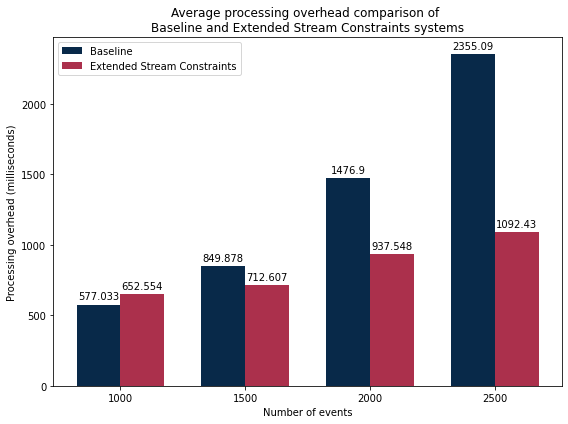

In [117]:
fig, ax = plt.subplots(figsize=(8,6))

labels = ['1000', '1500', '2000', '2500']
baseline_diff_mean = [mean(baseline_diffs_1000), mean(baseline_diffs_1500), mean(baseline_diffs_2000), mean(baseline_diffs_2500)]
constrained_diff_mean = [mean(constrained_diffs_1000), mean(constrained_diffs_1500), mean(constrained_diffs_2000), mean(constrained_diffs_2500)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, baseline_diff_mean, width, label='Baseline', color='#082949')
rects2 = ax.bar(x + width/2, constrained_diff_mean, width, label='Extended Stream Constraints', color='#ab304c')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Number of events')
ax.set_ylabel('Processing overhead (milliseconds)')
ax.set_title('Average processing overhead comparison of \nBaseline and Extended Stream Constraints systems')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.tight_layout()

plt.show()

fig.savefig("baseline-constrained-overhead.pdf")

## Comparing Extended Constraints processing times

In [118]:
def cumulative_overhead_to_minutes(processed_events, eventType):
    constrained_events = list(filter(lambda x: x[3] == eventType, processed_events))
    constrained_diffs =  list(map(lambda x: (int(x[2]) - int(x[1]))/1000.0, constrained_events)) # to seconds
    cumulative_diffs = [math.fsum(constrained_diffs[:i+1]) for i in range(len(constrained_diffs))]
    rounded_cumulative_diffs = list(map(lambda x: round(x/60.0,3), cumulative_diffs)) # to minutes
    return rounded_cumulative_diffs

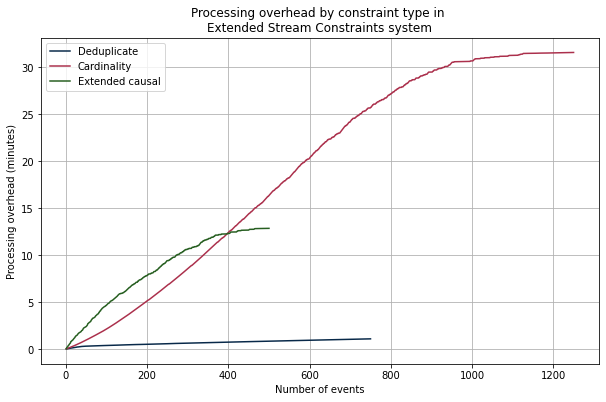

In [119]:
fig = plt.figure(figsize =(10, 6))

duplicates_2500_y = cumulative_overhead_to_minutes(processed_events_2500_constrained_list, "InsuranceQuoteRequestEvent")
duplicates_2500_x = list(range(1,len(duplicates_2500_y)+1))

limit_2500_y = cumulative_overhead_to_minutes(processed_events_2500_constrained_list, "UpdatePolicyEvent")
limit_2500_x = list(range(1,len(limit_2500_y)+1))

causal_2500_y = cumulative_overhead_to_minutes(processed_events_2500_constrained_list, "DeletePolicyEvent")
causal_2500_x = list(range(1,len(causal_2500_y)+1))

plt.plot(duplicates_2500_x, duplicates_2500_y, label="Deduplicate", color="#082949")
plt.plot(limit_2500_x, limit_2500_y, label="Cardinality", color="#ab304c")
plt.plot(causal_2500_x, causal_2500_y, label="Extended causal", color="#265E20")

plt.legend(loc="best")
plt.xlabel("Number of events")
plt.ylabel("Processing overhead (minutes)")
plt.grid(True)
plt.title("Processing overhead by constraint type in \nExtended Stream Constraints system")
plt.show()

fig.savefig("constrained-overhead-by-constraint-2500.pdf")

## Error counts comparison between Baseline and Extended Stream Constraint systems

500


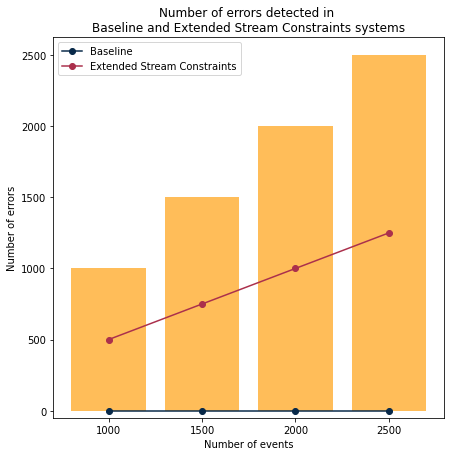

In [120]:
fig = plt.figure(figsize =(7, 7))

_, redirect_events_1000_constrained_list = create_event_map("extended-events-redirect-1000.txt")
_, redirect_events_1500_constrained_list = create_event_map("extended-events-redirect-1500.txt")
_, redirect_events_2000_constrained_list = create_event_map("extended-events-redirect-2000.txt")
_, redirect_events_2500_constrained_list = create_event_map("extended-events-redirect-2500.txt")

print(len(redirect_events_1000_constrained_list))
  
events = ['1000', '1500', '2000', '2500']
number_of_events_processed = [len(baseline_diffs_1000), len(baseline_diffs_1500), len(baseline_diffs_2000), len(baseline_diffs_2500)]
baseline_errors = [0, 0, 0, 0]
constrained_errors = [len(redirect_events_1000_constrained_list), len(redirect_events_1500_constrained_list), len(redirect_events_2000_constrained_list), len(redirect_events_2500_constrained_list)]


plt.bar(events,number_of_events_processed, color="#ffbd59")
plt.plot(events, baseline_errors, marker='o',  label='Baseline', color='#082949')
plt.plot(events, constrained_errors, marker='o',  label='Extended Stream Constraints', color='#ab304c')

plt.legend(loc="best")
plt.xlabel("Number of events")
plt.ylim(-50)
plt.ylabel("Number of errors")
plt.title("Number of errors detected in \nBaseline and Extended Stream Constraints systems")

plt.show()

fig.savefig("baseline-constrained-errors-detected.pdf")